# Predicting Lending Decisions: Analysis of the LendingClub Dataset IV part

In this part machine learning models will be trained to predict the subgrade of a person whose loan applications are accepted. 

### Importing libraries for the IV part

The main libraries which will be used for the manipulation with data are pandas and numpy. Matplotlib, seaborn and yellowbrick will be used for data visualization. Scipy, Statsmodels, Researchpy, Math, Random will be used for conducting statistical tests, calculating confidence intervals. Sklearn will be used for spliting data into training and testing samples, building and testing machine learning models.

In [2]:
import numpy as np 
import pandas as pd
import sqlite3
import duckdb
import random
import math

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

from scipy import stats
from scipy.stats import chi2_contingency, norm 
import researchpy as rp

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import optuna

import sklearn
import sklearn.ensemble
import sklearn.model_selection
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder, FunctionTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, f1_score, \
 precision_score, recall_score, confusion_matrix, mean_absolute_error,\
mean_squared_error,mean_squared_log_error,r2_score

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier

from imblearn.pipeline import make_pipeline, Pipeline as imbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

from yellowbrick.classifier import confusion_matrix, ClassificationReport

import joblib
import shap

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from lending_utils import *

## IV. PREDICTING A SUBGRADE FOR THE LOAN¶

### Importing the data

For this part only the dataset 'accepted.csv' will be needed for the analysis. This dataset is imported and saved into pandas dataframe.

In [3]:
accepted = pd.read_csv("data/accepted.csv")


### Preparing the data for the further analysis

The data will be prepared with the same steps as in the I part.

It can be seen that the dataframe "accepted", beginning from the row index 2260699, includes rows with missing data. These rows are removed from the dataframe.

Also, geographical and personal data would certainly not be used for the analysis, thus, these columns were removed from the dataframes.

In [4]:
accepted_mod = accepted.loc[:2260698, :]

In [5]:
accepted_mod = accepted_mod.drop(columns=["id", 'member_id', 'url', 'zip_code', 'addr_state'])


#### Initial feature selection

The initial list of features is selected based on the descriptions of these features in the data dictionary https://www.kaggle.com/datasets/adarshsng/lending-club-loan-data-csv?select=LCDataDictionary.xlsx. The selection of the features is not well-justified, as the time to understand the financial data for this project is limited. Also, features such as emp_length, risk_score are prepared as in the same way as in the part I.

The same features are selected as in the III part.

In [6]:
subgrade_prediction = accepted_mod[["sub_grade","loan_amnt", "loan_status",
                                 "emp_length",
                                 "delinq_2yrs", 
                             'fico_range_low','fico_range_high',
                                 'annual_inc',
                             'inq_last_6mths','pub_rec',
                             'revol_util',
                                 'home_ownership',
                                 'purpose',
                            'total_acc','initial_list_status',
                             'dti','acc_now_delinq',
                            'tot_cur_bal','il_util','all_util',
                             'inq_fi','inq_last_12m','chargeoff_within_12_mths',
                            'delinq_amnt','mths_since_last_major_derog',
                            'mths_since_last_record','mths_since_recent_bc_dlq',
                            'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
                            'pct_tl_nvr_dlq','pub_rec_bankruptcies','tot_hi_cred_lim',
                             'total_bc_limit','total_il_high_credit_limit',
                            'verification_status']]

In [7]:
subgrade_prediction_mod = duckdb.sql("""SELECT
                     sub_grade,
                     loan_amnt AS loan_amount,
                      CASE
                      WHEN emp_length = '< 1 year' THEN 0
                      WHEN emp_length = '1 year' THEN 1
                      WHEN emp_length = '2 years' THEN 2
                      WHEN emp_length = '3 years' THEN 3
                      WHEN emp_length = '4 years' THEN 4
                      WHEN emp_length = '5 years' THEN 5
                      WHEN emp_length = '6 years' THEN 6
                      WHEN emp_length = '7 years' THEN 7
                      WHEN emp_length = '8 years' THEN 8
                      WHEN emp_length = '9 years' THEN 9
                      ELSE 10 END AS emp_length,
                     annual_inc, loan_status, delinq_2yrs,
                         (fico_range_low + fico_range_high)/2 AS risk_score,
                             inq_last_6mths,pub_rec,
                             revol_util,
                            total_acc,initial_list_status,
                             dti,acc_now_delinq,
                            tot_cur_bal,il_util,all_util,
                                 home_ownership,
                                 purpose,
                             inq_fi,inq_last_12m,chargeoff_within_12_mths,
                            delinq_amnt,mths_since_last_major_derog,
                            mths_since_last_record,mths_since_recent_bc_dlq,
                            mths_since_recent_inq, mths_since_recent_revol_delinq,
                            pct_tl_nvr_dlq,pub_rec_bankruptcies,tot_hi_cred_lim,
                             total_bc_limit,total_il_high_credit_limit,
                            verification_status
                      FROM subgrade_prediction
                            """).df()
pd.set_option('display.max_columns', 500)
subgrade_prediction_mod.head()

,sub_grade,loan_amount,emp_length,annual_inc,loan_status,delinq_2yrs,risk_score,inq_last_6mths,pub_rec,revol_util,total_acc,initial_list_status,dti,acc_now_delinq,tot_cur_bal,il_util,all_util,home_ownership,purpose,inq_fi,inq_last_12m,chargeoff_within_12_mths,delinq_amnt,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,pct_tl_nvr_dlq,pub_rec_bankruptcies,tot_hi_cred_lim,total_bc_limit,total_il_high_credit_limit,verification_status
0,C4,3600.0,10,55000.0,Fully Paid,0.0,677.0,1.0,0.0,29.7,13.0,w,5.91,0.0,144904.0,36.0,34.0,MORTGAGE,debt_consolidation,3.0,4.0,0.0,0.0,30.0,NaN,69.0,4.0,69.0,76.9,0.0,178050.0,2400.0,13734.0,Not Verified
1,C1,24700.0,10,65000.0,Fully Paid,1.0,717.0,4.0,0.0,19.2,38.0,w,16.06,0.0,204396.0,73.0,29.0,MORTGAGE,small_business,0.0,6.0,0.0,0.0,NaN,NaN,NaN,0.0,6.0,97.4,0.0,314017.0,79300.0,24667.0,Not Verified
2,B4,20000.0,10,63000.0,Fully Paid,0.0,697.0,0.0,0.0,56.2,18.0,w,10.78,0.0,189699.0,73.0,65.0,MORTGAGE,home_improvement,2.0,1.0,0.0,0.0,NaN,NaN,NaN,10.0,NaN,100.0,0.0,218418.0,6200.0,14877.0,Not Verified
3,C5,35000.0,10,110000.0,Current,0.0,787.0,0.0,0.0,11.6,17.0,w,17.06,0.0,301500.0,70.0,45.0,MORTGAGE,debt_consolidation,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,100.0,0.0,381215.0,62500.0,18000.0,Source Verified
4,F1,10400.0,3,104433.0,Fully Paid,1.0,697.0,3.0,0.0,64.5,35.0,w,25.37,0.0,331730.0,84.0,78.0,MORTGAGE,major_purchase,2.0,3.0,0.0,0.0,NaN,NaN,12.0,1.0,12.0,96.6,0.0,439570.0,20300.0,88097.0,Source Verified


As categorical and numerical feature variables were examined in the III part, in this part the exploratory analysis of these variables will not be presented. 

#### 'Subgrade' as a target variable

The distribution of the subgrade variable is presented bellow.

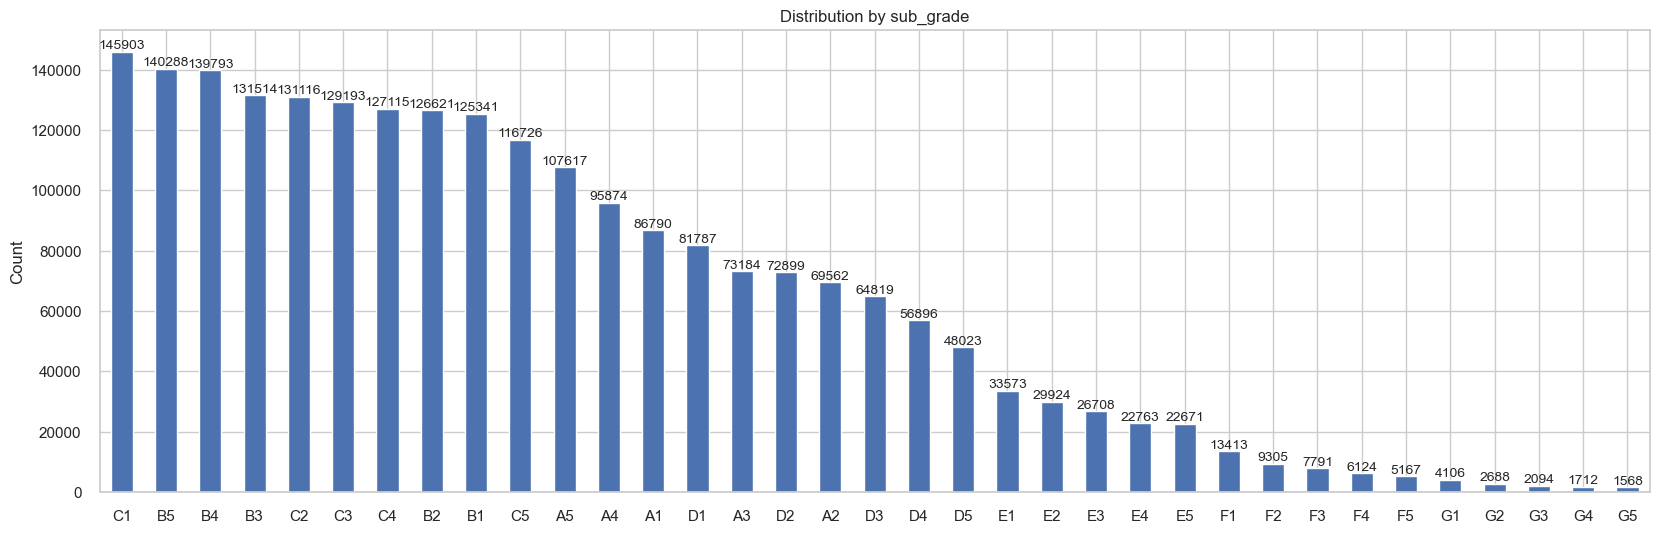

In [8]:
plt.figure(figsize=[20,6])

ax = subgrade_prediction_mod["sub_grade"].value_counts().plot(kind="bar")
plt.title("Distribution by sub_grade", fontsize=12)
plt.xticks(rotation=0)
plt.ylabel("Count", fontsize=12)

# Add value labels on top of each bar
for i, count in enumerate(subgrade_prediction_mod["sub_grade"].value_counts()):
    ax.text(i, count + 5, str(count), ha='center', va='bottom', fontsize=10)

# Show the plot
plt.show();

It can be seen that average subgrades C1, B5, B4, B3 are the most popular. 

### Examining relationships between categorical feature variables and a target variable

The dataframe with categorical variables is created. 

In [9]:
subgrade_prediction_describe = subgrade_prediction_mod.describe()

In [10]:
subgrade_prediction_cat = subgrade_prediction_mod.copy()
for i in range(len(subgrade_prediction_describe.columns)):
    subgrade_prediction_cat =  subgrade_prediction_cat.drop(columns = [subgrade_prediction_describe.columns[i]])                                   
   

In [11]:
subgrade_prediction_cat.head()

,sub_grade,loan_status,initial_list_status,home_ownership,purpose,verification_status
0,C4,Fully Paid,w,MORTGAGE,debt_consolidation,Not Verified
1,C1,Fully Paid,w,MORTGAGE,small_business,Not Verified
2,B4,Fully Paid,w,MORTGAGE,home_improvement,Not Verified
3,C5,Current,w,MORTGAGE,debt_consolidation,Source Verified
4,F1,Fully Paid,w,MORTGAGE,major_purchase,Source Verified


In order to examine which of the categorical feature variables has a effect on the target variable, chi square tests were performed.

In [12]:
frames = {}
for i in range(0, (len(subgrade_prediction_cat.columns)-1)):
    table = pd.crosstab(subgrade_prediction_cat.loc[:,"sub_grade"],subgrade_prediction_cat.iloc[:,i], dropna=False)
    table = (table/table.sum()*100).round(2)
    frames[i]=pd.DataFrame(table).transpose()

for i in range(1,len(frames)):
    print(frames[i])
    print('')

sub_grade                                             A1    A2    A3    A4  \
loan_status                                                                  
Charged Off                                         0.52  0.65  0.78  1.34   
Current                                             4.88  3.65  3.96  4.90   
Default                                             2.50  0.00  2.50  2.50   
Does not meet the credit policy. Status:Charged...  0.00  0.39  0.00  0.00   
Does not meet the credit policy. Status:Fully Paid  0.15  0.45  0.65  0.96   
Fully Paid                                          3.93  3.29  3.33  4.52   
In Grace Period                                     0.91  1.03  1.33  1.96   
Late (16-30 days)                                   0.97  1.24  1.26  2.21   
Late (31-120 days)                                  0.68  0.87  1.14  1.55   

sub_grade                                             A5    B1    B2    B3  \
loan_status                                                    

In [13]:
def chi_square_test(data, confidence, variable):
    stat, p, dof, expected = stats.chi2_contingency(data)
    alpha = 1 - confidence
    print(f'Pearson chi square test:{stat.round(3)}')
    print(f'P_value: {p.round(3)}')
    return p

In [14]:
conf_levels = [0.9, 0.95, 0.99]
for conf_level in conf_levels:
    significant = []
    unsignificant = [] 
    accepted_list = []
    rejected_list = []
    print(f'Confidence level - {conf_level}:')
    print('')
    for i in range(1,len(frames)):
        p = chi_square_test(frames[i], conf_level, subgrade_prediction_cat.columns[i])
        if p <= 1 - conf_level:
            print('')
            print(f'With regard to the variable {subgrade_prediction_cat.columns[i]},\
there are statistically signifficant differences among \ngroups of persons \
with different subgrades (the H0 hypothesis is rejected).')
            print('')
            significant.append(subgrade_prediction_cat.columns[i])
        else:
            print('')
            print(f'With regard to the variable {subgrade_prediction_cat.columns[i]},\
there are no statistically signifficant differences among \ngroups of persons \
with different subgrades (the H0 hypothesis is not rejected).')
            print('')
            unsignificant.append(subgrade_prediction_cat.columns[i])
    print('')
    print('')
    print(f'Significant statistical differences in groups of persons \
with different subgrades are for these variables:\n\
    {significant})')
    print(f'Unsignificant statistical differences in groups of of persons \
with different subgrades are for these variables:\n\
    {unsignificant})')
    print('')
    print('')

Confidence level - 0.9:

Pearson chi square test:222.058
P_value: 0.988

With regard to the variable loan_status,there are no statistically signifficant differences among 
groups of persons with different subgrades (the H0 hypothesis is not rejected).

Pearson chi square test:4.481
P_value: 1.0

With regard to the variable initial_list_status,there are no statistically signifficant differences among 
groups of persons with different subgrades (the H0 hypothesis is not rejected).

Pearson chi square test:116.342
P_value: 0.999

With regard to the variable home_ownership,there are no statistically signifficant differences among 
groups of persons with different subgrades (the H0 hypothesis is not rejected).

Pearson chi square test:99.452
P_value: 1.0

With regard to the variable purpose,there are no statistically signifficant differences among 
groups of persons with different subgrades (the H0 hypothesis is not rejected).



Significant statistical differences in groups of persons with

It can be observed that for all significance levels, no statistically significant differences are observed in categorical variables with regard to the target variable 'grade'. 


### Examining relationships between numeric variables

See the III part.

#### Checking for missing values

See the III part. 

#### Cleaning the data

Data are cleaned in the same ways as in the III part. 

Rows with missing values for some of variables were removed. It was supposed that it would not negativelly affect the analysis as there are still a lot of data left.

In [15]:
subgrade_prediction_mod1 = subgrade_prediction_mod.dropna(subset=['sub_grade','dti','revol_util','pub_rec_bankruptcies',
                                                                'chargeoff_within_12_mths','inq_last_6mths'])
subgrade_prediction_mod1.isnull().sum() 

sub_grade                               0
loan_amount                             0
emp_length                              0
annual_inc                              0
loan_status                             0
delinq_2yrs                             0
risk_score                              0
inq_last_6mths                          0
pub_rec                                 0
revol_util                              0
total_acc                               0
initial_list_status                     0
dti                                     0
acc_now_delinq                          0
tot_cur_bal                         68817
il_util                           1066175
all_util                           864299
home_ownership                          0
purpose                                 0
inq_fi                             864299
inq_last_12m                       864299
chargeoff_within_12_mths                0
delinq_amnt                             0
mths_since_last_major_derog       

##### Dropping rows with certain values

Rows with small numbers of values for some of the variables were dropped from the dataset in order to avoid the data not being present in either training or test datasets. 

In [16]:
subgrade_prediction_mod2 = subgrade_prediction_mod1[(subgrade_prediction_mod1["loan_status"] != "Default") & \
    (subgrade_prediction_mod1["loan_status"] != "Does not meet the credit policy. Status:Charged Off") & \
     (subgrade_prediction_mod1["loan_status"] != "Does not meet the credit policy. Status:Fully Paid") &\
     (subgrade_prediction_mod1["loan_status"] != "Late (31-120 days)") &\
     (subgrade_prediction_mod1["loan_status"] != "Late (16-30 days)")]


In [17]:
subgrade_prediction_mod2 = subgrade_prediction_mod2[(subgrade_prediction_mod2["purpose"] != "wedding") & \
    (subgrade_prediction_mod2["purpose"] != "educational") & \
     (subgrade_prediction_mod2["purpose"] != "renewable_energy") &\
    (subgrade_prediction_mod2["purpose"] != "house")]

In [18]:
subgrade_prediction_mod2 = subgrade_prediction_mod2[(subgrade_prediction_mod2["home_ownership"] != "ANY") & \
    (subgrade_prediction_mod2["home_ownership"] != "NONE") & \
     (subgrade_prediction_mod2["home_ownership"] != "OTHER")]

In [19]:
subgrade_prediction_mod2.value_counts("loan_status")

loan_status
Fully Paid         1066205
Current             868460
Charged Off         265964
In Grace Period       8351
dtype: int64

##### Dropping rows with values which are out of scales

Rows with values which do not fit into scale for such variable as 'dti' were also removed.

In [20]:
subgrade_prediction_mod2 = subgrade_prediction_mod2[(subgrade_prediction_mod2.dti <= 100)&(subgrade_prediction_mod2.dti > 0)]

##### Dropping certain variables

After the correlation analysis one of two highly correlated features (such as 'tol_cur_bal' and 'tot_hi_cred_lim' and 'mths_since_recent_bc_dlq' and 'mths_since_recent_revol_delinq') was removed from the data set. Also, some features which are not well undestood or were supposed to characterize companies and not individuals or having highly skewed distributions were also removed from the list of features. 

In [21]:
subgrade_prediction_mod3 = subgrade_prediction_mod2.drop(columns = ['tot_hi_cred_lim', 
                                                                'mths_since_recent_bc_dlq', 
                                                                'mths_since_last_major_derog',
                                                                'mths_since_last_record',
                                                               'mths_since_recent_inq',
                                                                'tot_cur_bal',
                                                                'mths_since_recent_revol_delinq',
                                                               'il_util', 'all_util',
                                                                'inq_fi','inq_last_12m',
                                                               'pct_tl_nvr_dlq','total_bc_limit',
                                                                'total_il_high_credit_limit'])

### Machine learning

#### Randomly selecting the data for machine learning

For machine learning purposes the the random sample of 10000 rows was selected.

In [23]:
subgrade_prediction_sample = subgrade_prediction_mod3.sample(n=40000)
subgrade_prediction_sample.head()

,sub_grade,loan_amount,emp_length,annual_inc,loan_status,delinq_2yrs,risk_score,inq_last_6mths,pub_rec,revol_util,total_acc,initial_list_status,dti,acc_now_delinq,home_ownership,purpose,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,verification_status
2231052,E1,16000.0,1,100000.0,Fully Paid,5.0,662.0,0.0,0.0,66.3,46.0,f,14.16,0.0,OWN,debt_consolidation,1.0,0.0,0.0,Source Verified
1344123,B3,25000.0,4,74000.0,Fully Paid,0.0,692.0,0.0,0.0,94.5,17.0,f,20.40,0.0,RENT,debt_consolidation,0.0,0.0,0.0,Verified
2089336,D2,10000.0,0,40000.0,Current,0.0,747.0,1.0,0.0,21.2,7.0,w,14.75,0.0,RENT,debt_consolidation,0.0,0.0,0.0,Source Verified
1731111,D1,10000.0,8,110000.0,Current,0.0,682.0,3.0,0.0,54.9,26.0,w,10.06,0.0,OWN,home_improvement,0.0,0.0,0.0,Not Verified
2109271,B1,2500.0,3,80000.0,Current,1.0,757.0,1.0,0.0,3.6,24.0,w,3.67,0.0,RENT,vacation,0.0,0.0,0.0,Not Verified


It can be seen that the sample has 19 features and one target variable.

In [24]:
subgrade_prediction_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 2231052 to 386415
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   sub_grade                 40000 non-null  object 
 1   loan_amount               40000 non-null  float64
 2   emp_length                40000 non-null  int32  
 3   annual_inc                40000 non-null  float64
 4   loan_status               40000 non-null  object 
 5   delinq_2yrs               40000 non-null  float64
 6   risk_score                40000 non-null  float64
 7   inq_last_6mths            40000 non-null  float64
 8   pub_rec                   40000 non-null  float64
 9   revol_util                40000 non-null  float64
 10  total_acc                 40000 non-null  float64
 11  initial_list_status       40000 non-null  object 
 12  dti                       40000 non-null  float64
 13  acc_now_delinq            40000 non-null  float64
 14 

#### Encoding the target variable and spliting the data into training and test datasets

First, the data were split into feature variables and target variable as well as into training and testing datasets. The target variable was encoded with the label encoder, the dictionary with coresponding keys (in order to know which keys represent which values) was created.

70 percent of data were included into the training dataset, 30 percent into the testing dataset. The training data set was split into  half (for training and validation).

In [25]:
X = subgrade_prediction_sample.drop(['sub_grade'],axis=1)
y = subgrade_prediction_sample['sub_grade']


In [26]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [27]:
labels = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print(labels)


{'A1': 0, 'A2': 1, 'A3': 2, 'A4': 3, 'A5': 4, 'B1': 5, 'B2': 6, 'B3': 7, 'B4': 8, 'B5': 9, 'C1': 10, 'C2': 11, 'C3': 12, 'C4': 13, 'C5': 14, 'D1': 15, 'D2': 16, 'D3': 17, 'D4': 18, 'D5': 19, 'E1': 20, 'E2': 21, 'E3': 22, 'E4': 23, 'E5': 24, 'F1': 25, 'F2': 26, 'F3': 27, 'F4': 28, 'F5': 29, 'G1': 30, 'G2': 31, 'G3': 32, 'G4': 33, 'G5': 34}


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, random_state=123, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.5, random_state=123, stratify = y_train)

#### Building a machine learning pipeline

Next, pipelines of transforming data were constructed. As for some categorical variables it was needed to encode them into numbers, one hot encoder function was applied. For numerical variables, standart scaler was applied to transform the variables into comparable scales.

In [29]:
numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
      ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


In [30]:
subgrade_prediction_mod3_describe = subgrade_prediction_mod3.describe()
print(subgrade_prediction_mod3_describe.columns)
subgrade_prediction_cat = subgrade_prediction_mod3.copy()
for i in range(len(subgrade_prediction_mod3_describe.columns)):
    subgrade_prediction_cat =  subgrade_prediction_cat.drop\
    (columns = [subgrade_prediction_mod3_describe.columns[i]])
print(subgrade_prediction_cat.columns)

Index(['loan_amount', 'emp_length', 'annual_inc', 'delinq_2yrs', 'risk_score',
       'inq_last_6mths', 'pub_rec', 'revol_util', 'total_acc', 'dti',
       'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt',
       'pub_rec_bankruptcies'],
      dtype='object')
Index(['sub_grade', 'loan_status', 'initial_list_status', 'home_ownership',
       'purpose', 'verification_status'],
      dtype='object')


In [31]:
numeric_features = ['loan_amount', 'emp_length', 'annual_inc', 'delinq_2yrs', 'risk_score',
       'inq_last_6mths', 'pub_rec', 'revol_util', 'total_acc', 'dti',
       'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt',
       'pub_rec_bankruptcies']
categorical_features = ['loan_status', 'initial_list_status', 'home_ownership',
       'purpose', 'verification_status']


In [32]:
preprocessor = ColumnTransformer(
   transformers=[
    ('numeric', numeric_transformer, numeric_features),
    ('categorical', categorical_transformer, categorical_features)
]) 

In [33]:
classifiers = [
    xgb.XGBClassifier()
    ,RandomForestClassifier()
    ,ExtraTreesClassifier()
    ,GradientBoostingClassifier()
    ,LogisticRegression()
    ,SVC()
    ,KNeighborsClassifier()
    ,BaggingClassifier()
    ,AdaBoostClassifier()]


#### Running the machine learning pipelines

Th function for running imbalanced pipeline, cross-validating, getting metrics and presenting outputs in different forms was used from lending_utils file. It was decided not to use random search hyperparameter tuning in order to save time.

In [34]:
classes_subgrade=['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1',
       'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2',
       'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3',
       'G4', 'G5']
size_subgrade = (1000, 1000)

In [35]:
def score_model(x_train, y_train, x_val, y_val, estimator, df, models_list, classes, size, **kwargs):
    
    # Model fitting and prediction:
    pipeline = imbPipeline(steps = [
                   ('preprocessor', preprocessor),
                    ('smote', SMOTE()),
                   ('classifier',classifier)])
    
    model = pipeline.fit(x_train, y_train)
    prediction = model.predict(x_val)
   
    # Cross-validation:
    scoring = {'accuracy': make_scorer(accuracy_score)}
    cross_val = cross_validate(model, x_train, y_train, cv=5, scoring=scoring)
    cross_vals.append(cross_val)
    accuracy_scores = cross_val['test_accuracy']
    
    #Metrics:
    f1 = f1_score(y_val, prediction, average='macro').round(3)
    prec = precision_score(y_val, prediction, average='macro').round(3)
    rec = recall_score(y_val, prediction, average='macro').round(3)
    acc_sq = accuracy_score(y_val, prediction).round(3)
    report = classification_report(y_val, prediction, target_names=classes)
    
    #Prints:
    print (estimator.__class__.__name__)
    conf = confusion_matrix(model, x_train, y_train, x_val, y_val, classes=classes,
        cmap="YlGn", size=size, **kwargs)
    print("Classification Report:")
    print(report)
    print (f'Cross-validation')
    print ("Accuracy scores: {}".format(accuracy_scores))
    avg_list = sum(list(accuracy_scores))/len(list(accuracy_scores))
    print (f"Accuracy score (average): {avg_list}")
    print('')
    
    #Appends:
    models_list.append(model)
    predictions.append(prediction)
    df["model_name"].append(f'{estimator.__class__.__name__}')
    df["a_score"].append(acc_sq)
    df["f1_score"].append(f1)
    df["precision_score"].append(prec)
    df["recall_score"].append(rec)

XGBClassifier


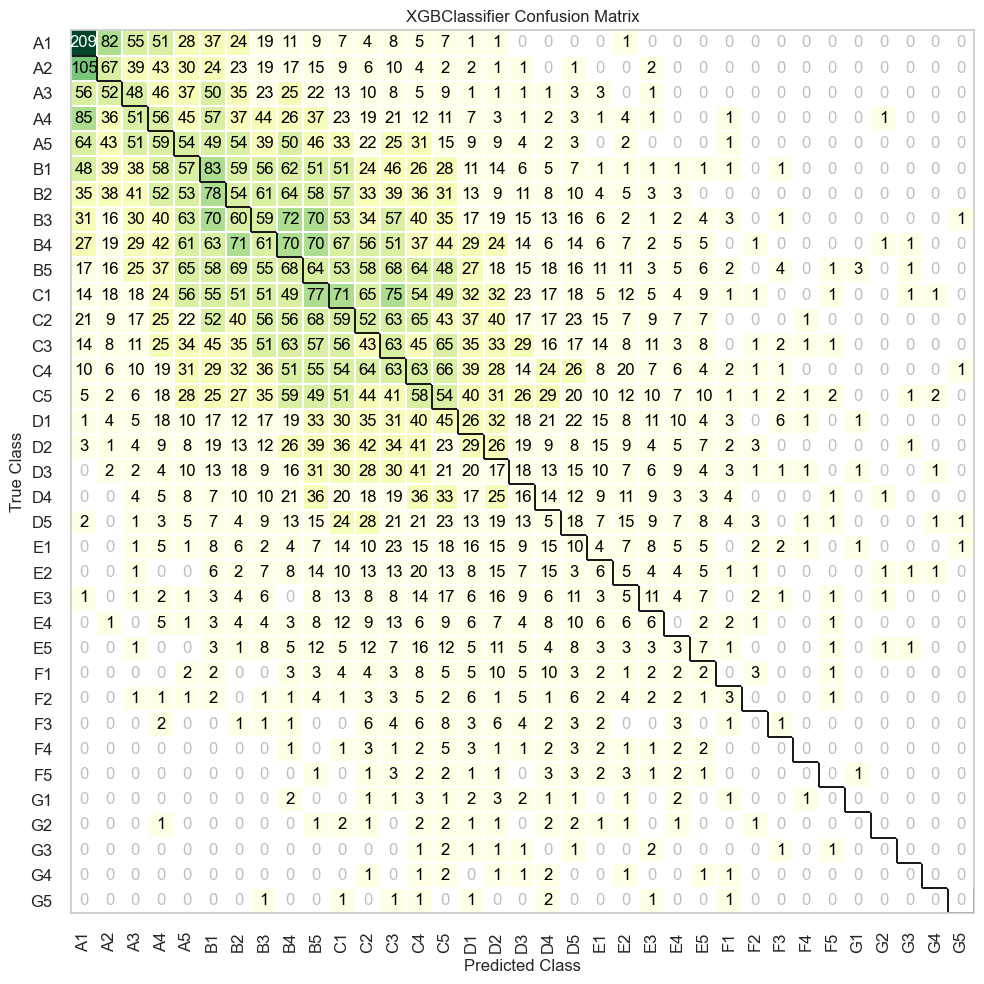

Classification Report:
              precision    recall  f1-score   support

          A1       0.28      0.37      0.32       559
          A2       0.15      0.16      0.15       420
          A3       0.10      0.11      0.10       450
          A4       0.09      0.10      0.09       584
          A5       0.08      0.08      0.08       665
          B1       0.10      0.11      0.10       776
          B2       0.07      0.07      0.07       796
          B3       0.08      0.07      0.07       830
          B4       0.08      0.08      0.08       883
          B5       0.07      0.07      0.07       906
          C1       0.08      0.08      0.08       889
          C2       0.07      0.06      0.07       828
          C3       0.07      0.08      0.08       794
          C4       0.08      0.08      0.08       770
          C5       0.07      0.08      0.07       707
          D1       0.06      0.05      0.05       495
          D2       0.06      0.06      0.06       447
    

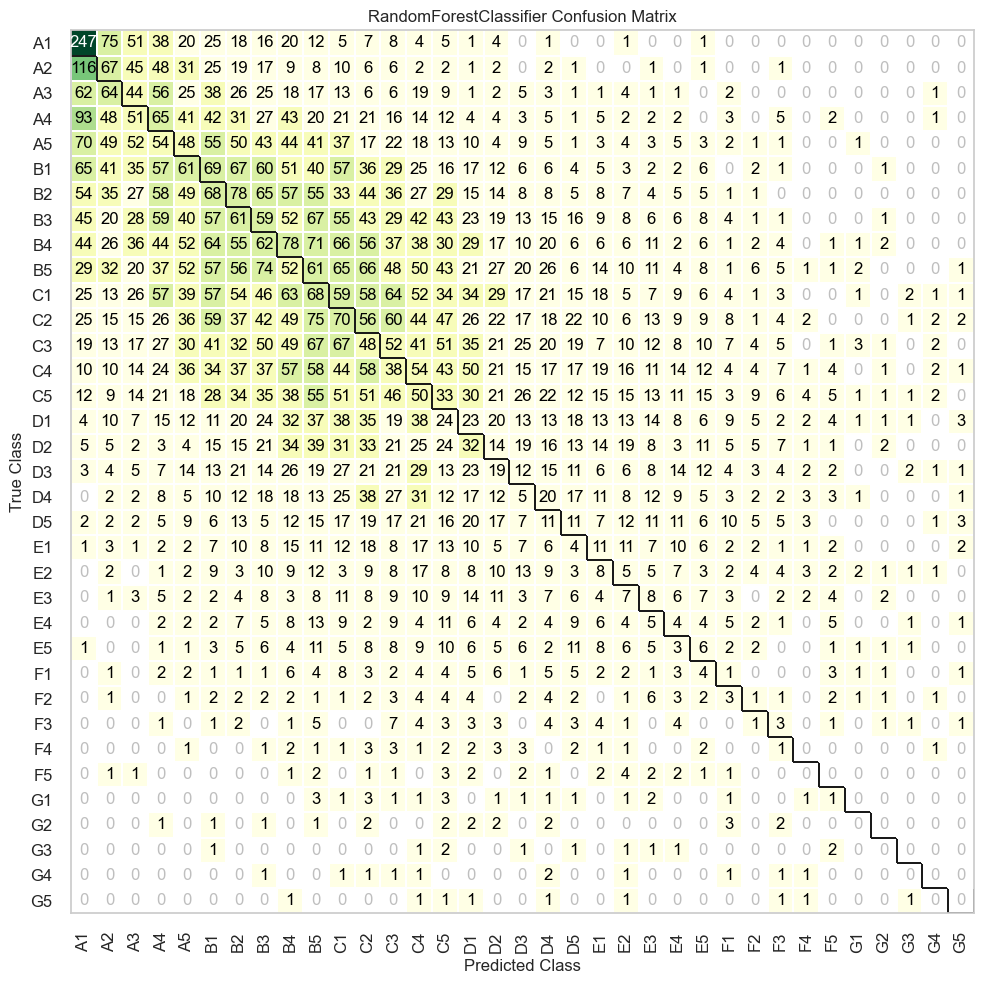

Classification Report:
              precision    recall  f1-score   support

          A1       0.27      0.44      0.33       559
          A2       0.12      0.16      0.14       420
          A3       0.09      0.10      0.09       450
          A4       0.09      0.11      0.10       584
          A5       0.08      0.07      0.07       665
          B1       0.09      0.09      0.09       776
          B2       0.10      0.10      0.10       796
          B3       0.08      0.07      0.07       830
          B4       0.09      0.09      0.09       883
          B5       0.07      0.07      0.07       906
          C1       0.07      0.07      0.07       889
          C2       0.07      0.07      0.07       828
          C3       0.08      0.07      0.07       794
          C4       0.08      0.07      0.07       770
          C5       0.06      0.05      0.05       707
          D1       0.05      0.05      0.05       495
          D2       0.04      0.03      0.04       447
    

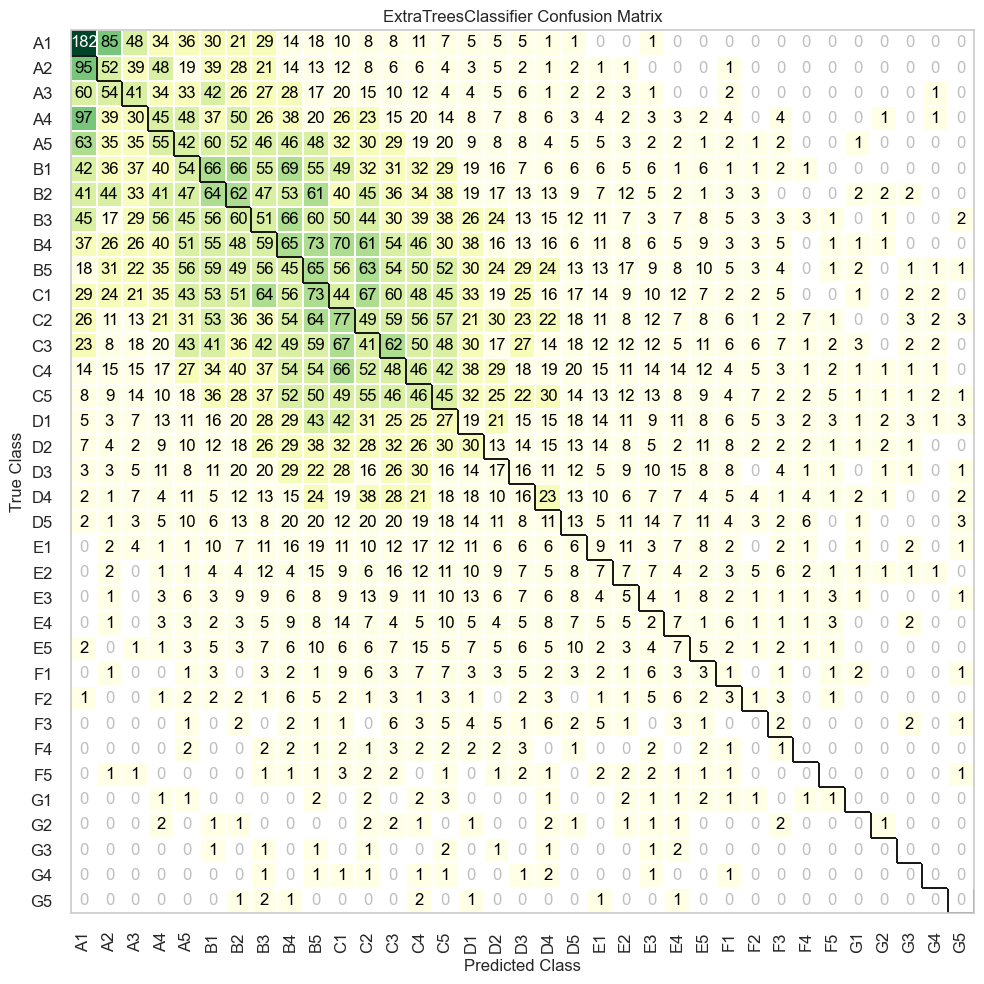

Classification Report:
              precision    recall  f1-score   support

          A1       0.23      0.33      0.27       559
          A2       0.10      0.12      0.11       420
          A3       0.09      0.09      0.09       450
          A4       0.08      0.08      0.08       584
          A5       0.06      0.06      0.06       665
          B1       0.08      0.09      0.08       776
          B2       0.08      0.08      0.08       796
          B3       0.07      0.06      0.06       830
          B4       0.07      0.07      0.07       883
          B5       0.07      0.07      0.07       906
          C1       0.05      0.05      0.05       889
          C2       0.06      0.06      0.06       828
          C3       0.08      0.08      0.08       794
          C4       0.06      0.06      0.06       770
          C5       0.07      0.06      0.07       707
          D1       0.04      0.04      0.04       495
          D2       0.04      0.03      0.03       447
    

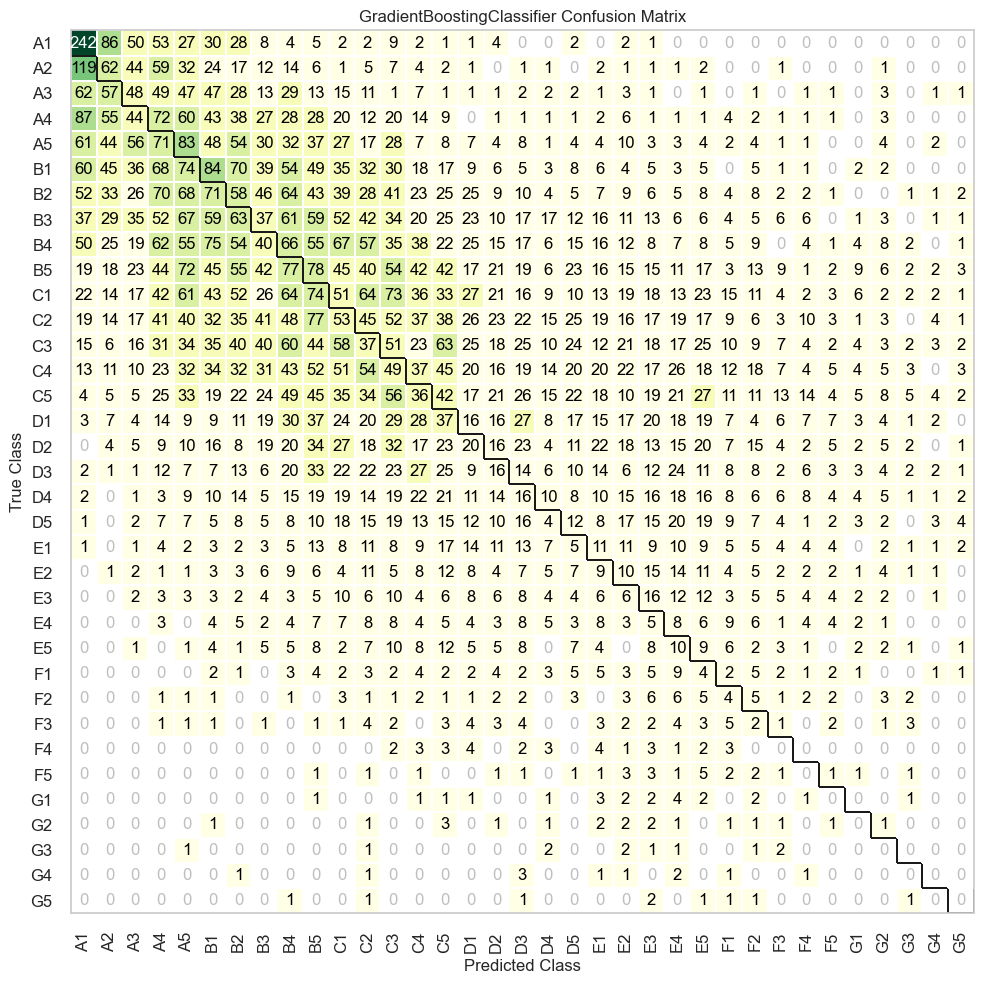

Classification Report:
              precision    recall  f1-score   support

          A1       0.28      0.43      0.34       559
          A2       0.12      0.15      0.13       420
          A3       0.10      0.11      0.10       450
          A4       0.09      0.12      0.10       584
          A5       0.10      0.12      0.11       665
          B1       0.11      0.11      0.11       776
          B2       0.08      0.07      0.08       796
          B3       0.07      0.04      0.05       830
          B4       0.08      0.07      0.08       883
          B5       0.09      0.09      0.09       906
          C1       0.07      0.06      0.06       889
          C2       0.07      0.05      0.06       828
          C3       0.07      0.06      0.07       794
          C4       0.07      0.05      0.06       770
          C5       0.08      0.06      0.07       707
          D1       0.05      0.03      0.04       495
          D2       0.06      0.04      0.04       447
    

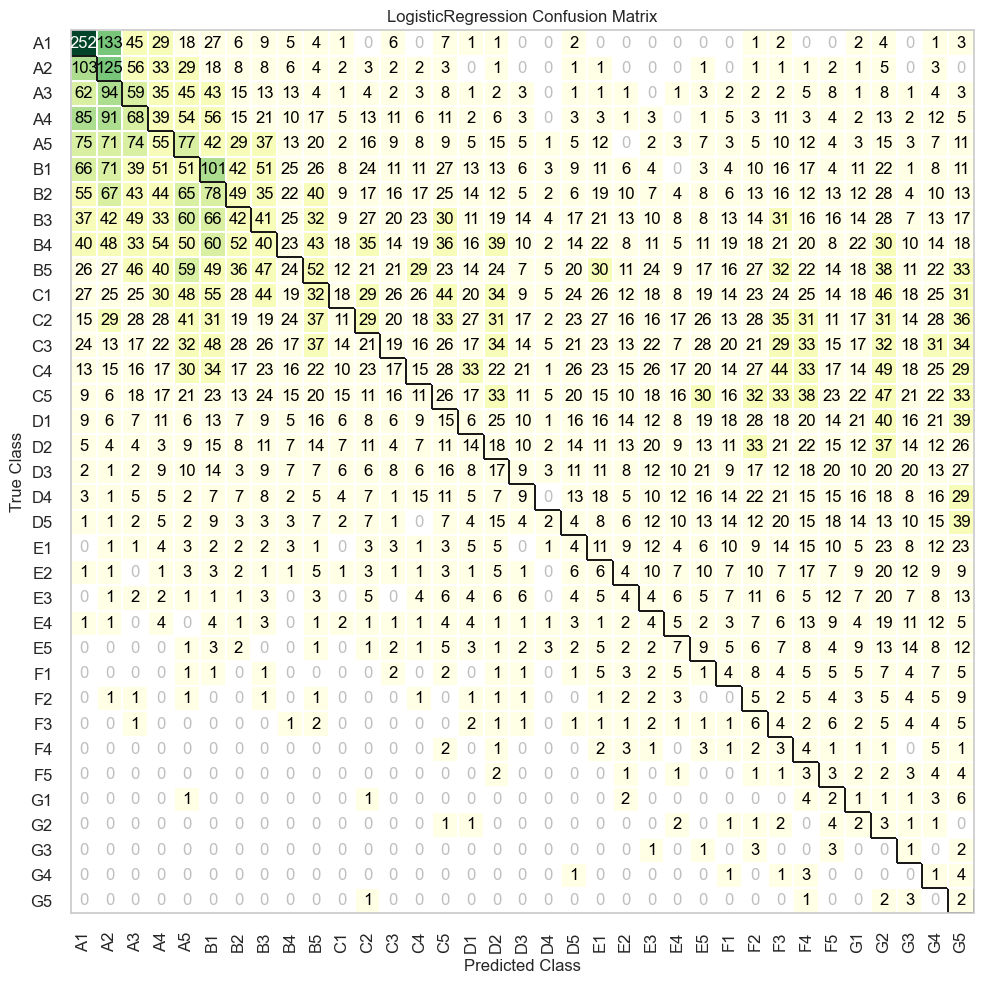

Classification Report:
              precision    recall  f1-score   support

          A1       0.28      0.45      0.34       559
          A2       0.14      0.30      0.19       420
          A3       0.09      0.13      0.11       450
          A4       0.07      0.07      0.07       584
          A5       0.11      0.12      0.11       665
          B1       0.13      0.13      0.13       776
          B2       0.11      0.06      0.08       796
          B3       0.08      0.05      0.06       830
          B4       0.08      0.03      0.04       883
          B5       0.11      0.06      0.08       906
          C1       0.11      0.02      0.03       889
          C2       0.09      0.04      0.05       828
          C3       0.08      0.02      0.04       794
          C4       0.06      0.02      0.03       770
          C5       0.06      0.04      0.05       707
          D1       0.02      0.01      0.02       495
          D2       0.05      0.04      0.04       447
    

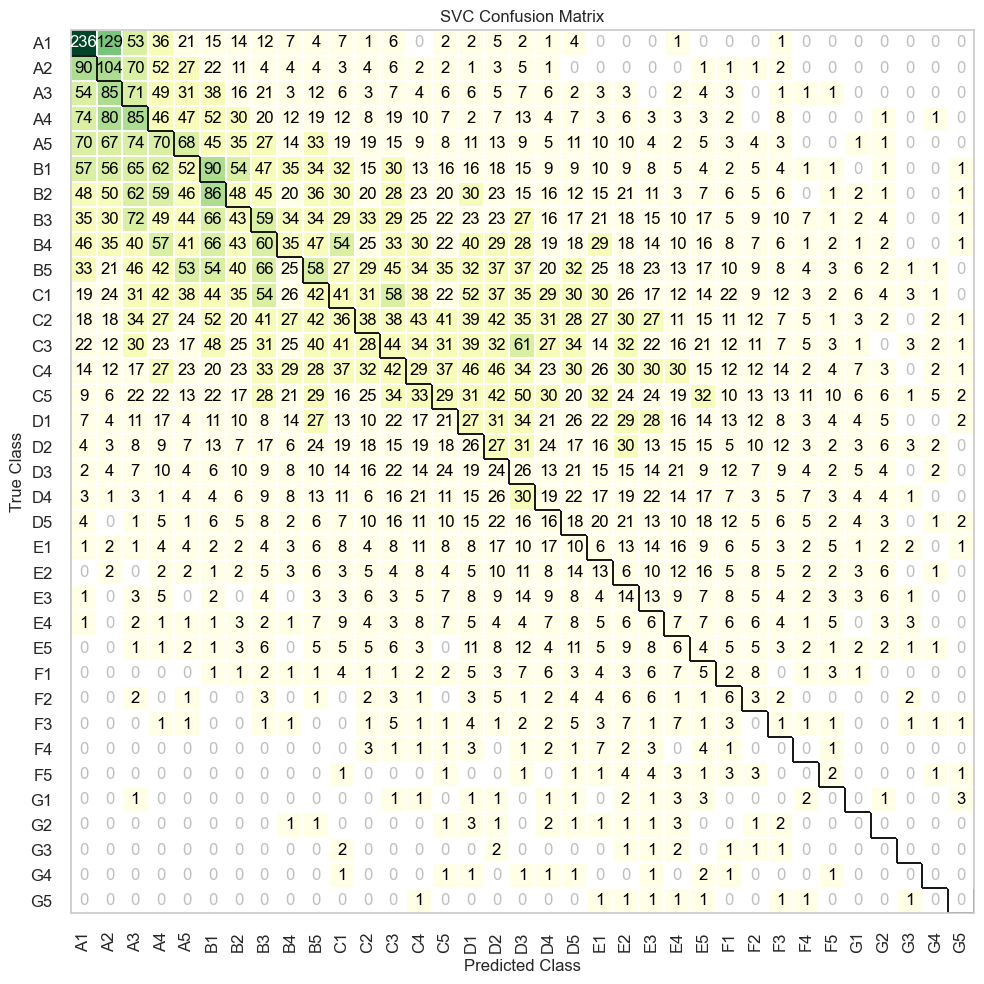

Classification Report:
              precision    recall  f1-score   support

          A1       0.28      0.42      0.34       559
          A2       0.14      0.25      0.18       420
          A3       0.09      0.16      0.11       450
          A4       0.06      0.08      0.07       584
          A5       0.12      0.10      0.11       665
          B1       0.12      0.12      0.12       776
          B2       0.10      0.06      0.07       796
          B3       0.09      0.07      0.08       830
          B4       0.10      0.04      0.06       883
          B5       0.10      0.06      0.08       906
          C1       0.08      0.05      0.06       889
          C2       0.09      0.05      0.06       828
          C3       0.08      0.06      0.06       794
          C4       0.06      0.04      0.05       770
          C5       0.07      0.04      0.05       707
          D1       0.05      0.05      0.05       495
          D2       0.05      0.06      0.05       447
    

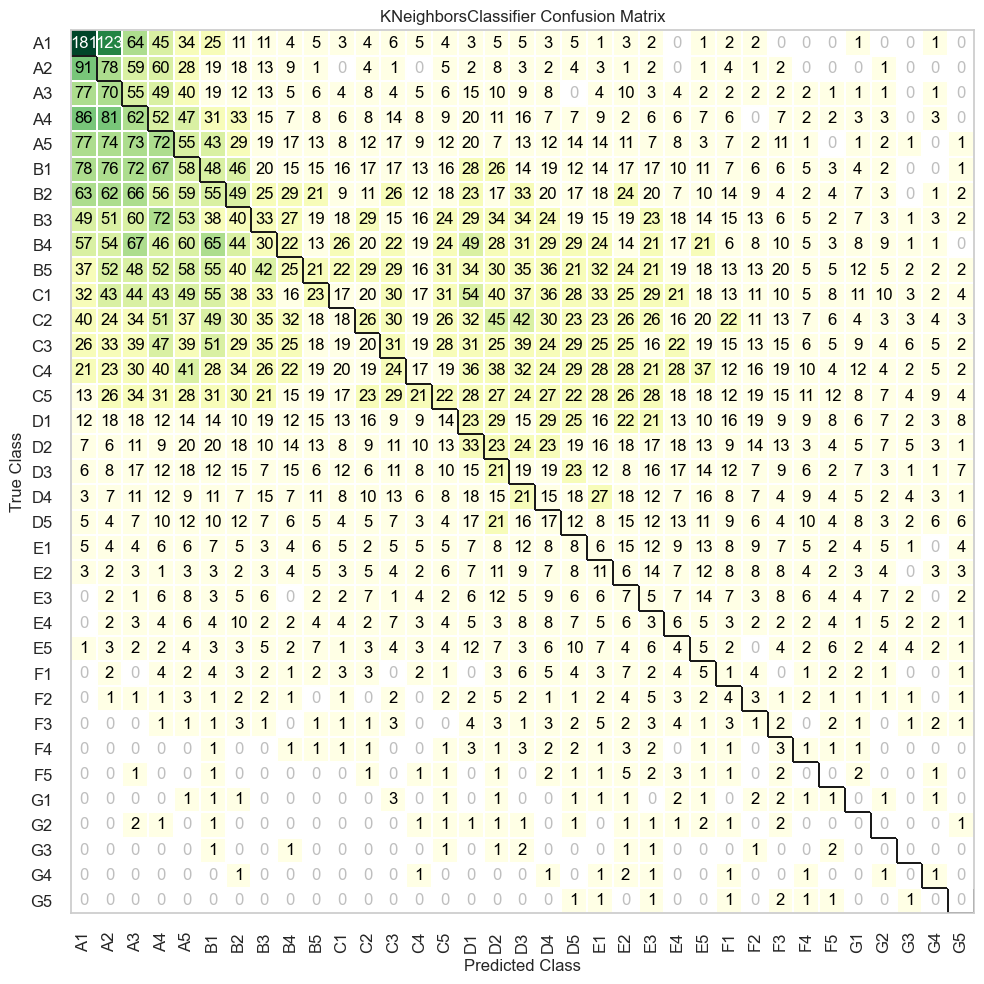

Classification Report:
              precision    recall  f1-score   support

          A1       0.19      0.32      0.24       559
          A2       0.08      0.19      0.12       420
          A3       0.06      0.12      0.08       450
          A4       0.06      0.09      0.07       584
          A5       0.07      0.08      0.08       665
          B1       0.07      0.06      0.06       776
          B2       0.08      0.06      0.07       796
          B3       0.07      0.04      0.05       830
          B4       0.06      0.02      0.04       883
          B5       0.07      0.02      0.03       906
          C1       0.06      0.02      0.03       889
          C2       0.08      0.03      0.05       828
          C3       0.08      0.04      0.05       794
          C4       0.07      0.02      0.03       770
          C5       0.06      0.03      0.04       707
          D1       0.04      0.05      0.04       495
          D2       0.04      0.05      0.05       447
    

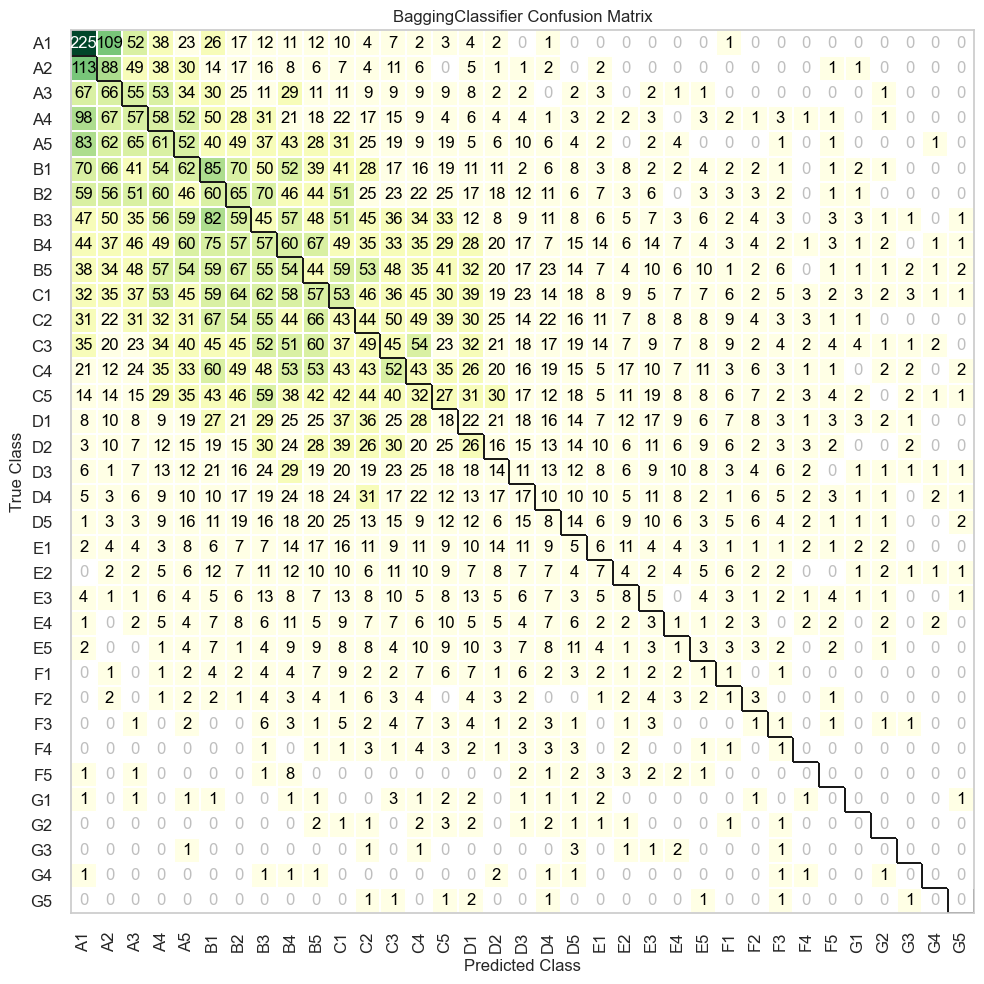

Classification Report:
              precision    recall  f1-score   support

          A1       0.22      0.40      0.29       559
          A2       0.11      0.21      0.15       420
          A3       0.08      0.12      0.10       450
          A4       0.07      0.10      0.08       584
          A5       0.07      0.08      0.07       665
          B1       0.09      0.11      0.10       776
          B2       0.08      0.08      0.08       796
          B3       0.05      0.05      0.05       830
          B4       0.07      0.07      0.07       883
          B5       0.06      0.05      0.05       906
          C1       0.07      0.06      0.06       889
          C2       0.07      0.05      0.06       828
          C3       0.07      0.06      0.06       794
          C4       0.08      0.06      0.06       770
          C5       0.06      0.04      0.05       707
          D1       0.05      0.04      0.05       495
          D2       0.05      0.04      0.04       447
    

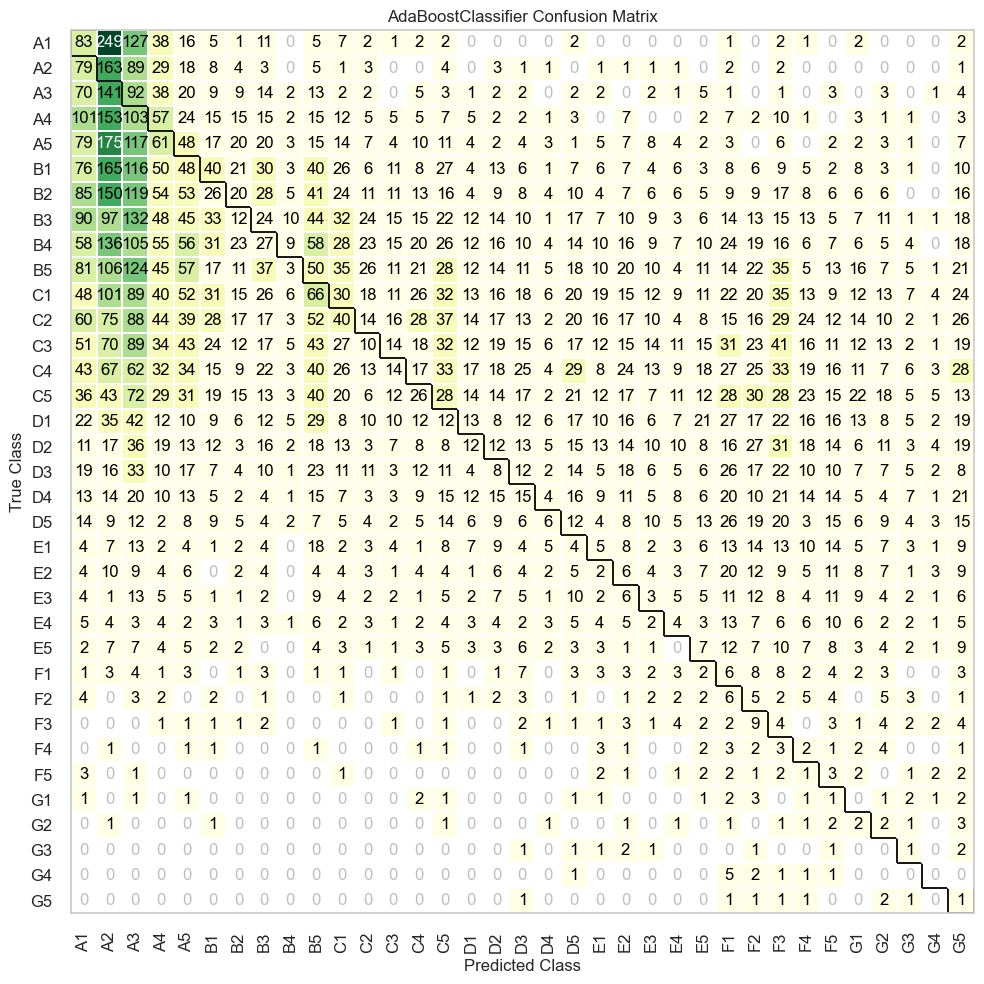

Classification Report:
              precision    recall  f1-score   support

          A1       0.07      0.15      0.10       559
          A2       0.08      0.39      0.13       420
          A3       0.05      0.20      0.08       450
          A4       0.08      0.10      0.09       584
          A5       0.07      0.07      0.07       665
          B1       0.11      0.05      0.07       776
          B2       0.09      0.03      0.04       796
          B3       0.07      0.03      0.04       830
          B4       0.13      0.01      0.02       883
          B5       0.08      0.06      0.06       906
          C1       0.08      0.03      0.05       889
          C2       0.07      0.02      0.03       828
          C3       0.08      0.02      0.03       794
          C4       0.06      0.02      0.03       770
          C5       0.07      0.04      0.05       707
          D1       0.07      0.03      0.04       495
          D2       0.05      0.03      0.03       447
    

In [69]:
cross_vals = []
models = []
predictions = []
scores = {}
scores["precision_score"] = []
scores["recall_score"] = []
scores["model_name"] = []
scores["a_score"] = []
scores["f1_score"] = []
for classifier in classifiers:
    score_model(X_train, y_train, X_val, y_val, classifier, scores, models, classes_subgrade, size_subgrade)


In [70]:
for model in models:
    joblib.dump(model, f'model_subgrade_classification{models.index(model)}.joblib')

In [74]:
scores = pd.DataFrame(scores).set_index("model_name")
scores.to_csv('scores_lending_subgrade_classification.csv')

In [78]:
scores = pd.DataFrame(scores).sort_values("recall_score", ascending = False)

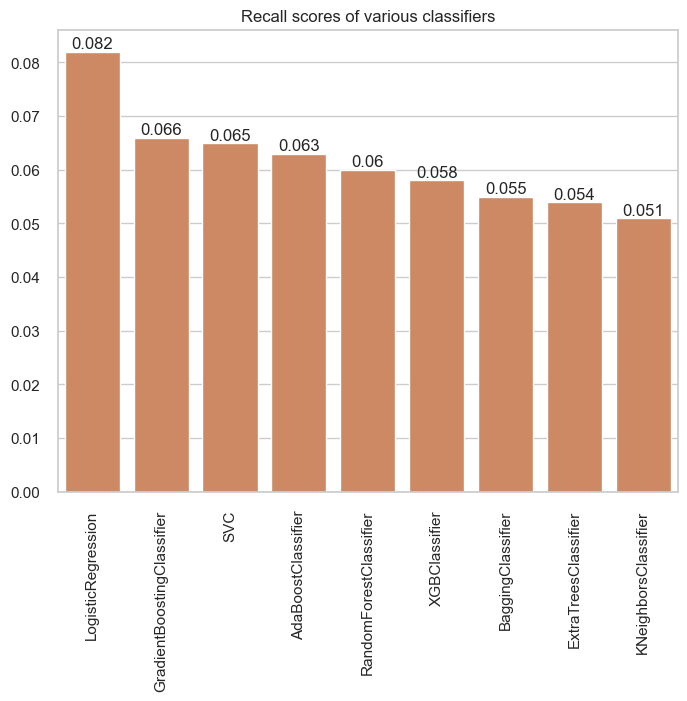

In [80]:
scores = pd.DataFrame(scores).sort_values("recall_score", ascending = False)
plot_bars(scores, "recall_score", "", "Recall scores of various classifiers")

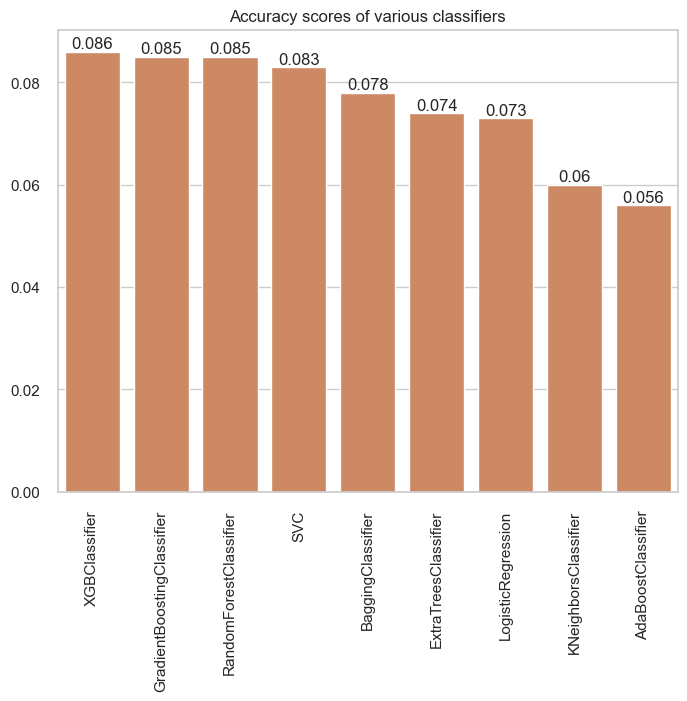

In [81]:
scores = pd.DataFrame(scores).sort_values("a_score", ascending = False)
plot_bars(scores, "a_score", "", "Accuracy scores of various classifiers")

It can be seen that the Logistic regression classifier has the highest recall score while the XgBoost classifier has the highest accuracy score. The scores are four times higher that random guessing with probability (1/35 or 0.02). The good option for the model choice is the gradient boosting classifier which has quite high both recall and accuracy scores.

#### Feature importances

As the feature selection based on feature importances in the III part did not generated higher accuracy scores as in the initial set of features, this approach will not be applied for training machine learning model for the prediction of subgrade. Thus, only the manual feature selection will be used.

##### 1) Manual feature selection for pipeline

In [36]:
num_feature_list = ['emp_length', 'risk_score','loan_amount', 'dti']
cat_feature_list = ['loan_status']


In [37]:
def feature_selector_for_preprocessor(num_feature_list, cat_feature_list):
    numeric_features_selected = num_feature_list
    categorical_features_selected = cat_feature_list
    preprocessor = ColumnTransformer(transformers=[
        ('numeric', numeric_transformer, numeric_features_selected),
        ('categorical', categorical_transformer, categorical_features_selected),
    ])
    return preprocessor

In order to simplify output confusion matrix and classification report were removed from the function for running models.

In [38]:
def score_model_simplified(x_train, y_train, x_val, y_val, estimator, df, models_list, classes, size, **kwargs):
    
    # Model fitting and prediction:
    pipeline = imbPipeline(steps = [
                   ('preprocessor', preprocessor),
                    ('smote', SMOTE()),
                   ('classifier',classifier)])
    
    model = pipeline.fit(x_train, y_train)
    prediction = model.predict(x_val)
   
    # Cross-validation:
    scoring = {'accuracy': make_scorer(accuracy_score)}
    cross_val = cross_validate(model, x_train, y_train, cv=5, scoring=scoring)
    cross_vals.append(cross_val)
    accuracy_scores = cross_val['test_accuracy']
    
    #Metrics:
    f1 = f1_score(y_val, prediction, average='macro').round(3)
    prec = precision_score(y_val, prediction, average='macro').round(3)
    rec = recall_score(y_val, prediction, average='macro').round(3)
    acc_sq = accuracy_score(y_val, prediction).round(3)
    report = classification_report(y_val, prediction, target_names=classes)
    
    #Prints:
    print (estimator.__class__.__name__)
    print (f'Cross-validation')
    print ("Accuracy scores: {}".format(accuracy_scores))
    avg_list = sum(list(accuracy_scores))/len(list(accuracy_scores))
    print (f"Accuracy score (average): {avg_list}")
    print('')
    
    #Appends:
    models_list.append(model)
    predictions.append(prediction)
    df["model_name"].append(f'{estimator.__class__.__name__}')
    df["a_score"].append(acc_sq)
    df["f1_score"].append(f1)
    df["precision_score"].append(prec)
    df["recall_score"].append(rec)

In [39]:
preprocessor = feature_selector_for_preprocessor(num_feature_list, cat_feature_list)

In [87]:
cross_vals = []
models_selected = []
predictions = []
scores_selected = {}
scores_selected["precision_score"] = []
scores_selected["recall_score"] = []
scores_selected["model_name"] = []
scores_selected["a_score"] = []
scores_selected["f1_score"] = []
for classifier in classifiers:
    score_model_simplified(X_train, y_train, X_val, y_val, classifier, scores_selected, 
                models_selected, classes_subgrade, size_subgrade)

XGBClassifier
Cross-validation
Accuracy scores: [0.06821429 0.07678571 0.07       0.07821429 0.07392857]
Accuracy score (average): 0.07342857142857144

RandomForestClassifier
Cross-validation
Accuracy scores: [0.06607143 0.06571429 0.06       0.06428571 0.06678571]
Accuracy score (average): 0.06457142857142857

ExtraTreesClassifier
Cross-validation
Accuracy scores: [0.0625     0.06285714 0.06571429 0.06321429 0.06642857]
Accuracy score (average): 0.06414285714285714

GradientBoostingClassifier
Cross-validation
Accuracy scores: [0.06678571 0.07142857 0.06428571 0.06428571 0.06107143]
Accuracy score (average): 0.06557142857142857

LogisticRegression
Cross-validation
Accuracy scores: [0.05857143 0.06678571 0.06214286 0.05642857 0.06964286]
Accuracy score (average): 0.06271428571428572

SVC
Cross-validation
Accuracy scores: [0.05321429 0.06071429 0.05       0.06178571 0.05964286]
Accuracy score (average): 0.05707142857142857

KNeighborsClassifier
Cross-validation
Accuracy scores: [0.061071

In [89]:
scores_selected = pd.DataFrame(scores_selected)
scores_selected = scores_selected.set_index('model_name')
scores_selected

,precision_score,recall_score,a_score,f1_score
model_name,,,,
XGBClassifier,0.048,0.054,0.074,0.050
RandomForestClassifier,0.047,0.052,0.068,0.048
ExtraTreesClassifier,0.048,0.052,0.070,0.049
GradientBoostingClassifier,0.053,0.057,0.072,0.050
LogisticRegression,0.047,0.073,0.061,0.041
SVC,0.048,0.062,0.059,0.042
KNeighborsClassifier,0.041,0.051,0.059,0.041
BaggingClassifier,0.044,0.048,0.068,0.045
AdaBoostClassifier,0.039,0.065,0.052,0.027


In [90]:
for model in models_selected:
    joblib.dump(model, f'model_selected_subgrade{models_selected.index(model)}.joblib')

In [91]:
#scores = pd.DataFrame(scores).set_index("model_name")
scores_selected.to_csv('scores_lending_selected.csv')

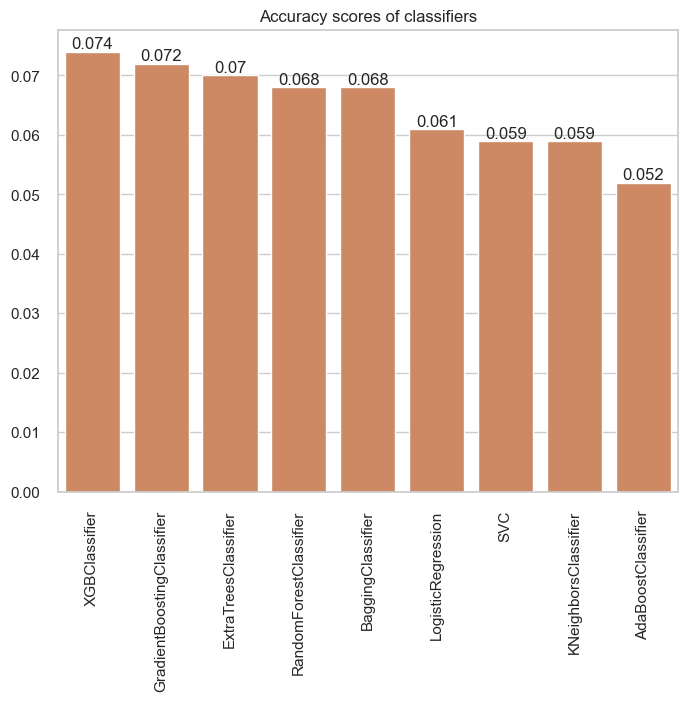

In [94]:
scores_selected = pd.DataFrame(scores_selected).sort_values("a_score", ascending = False)
plot_bars(scores_selected, "a_score", "", "Accuracy scores of classifiers")

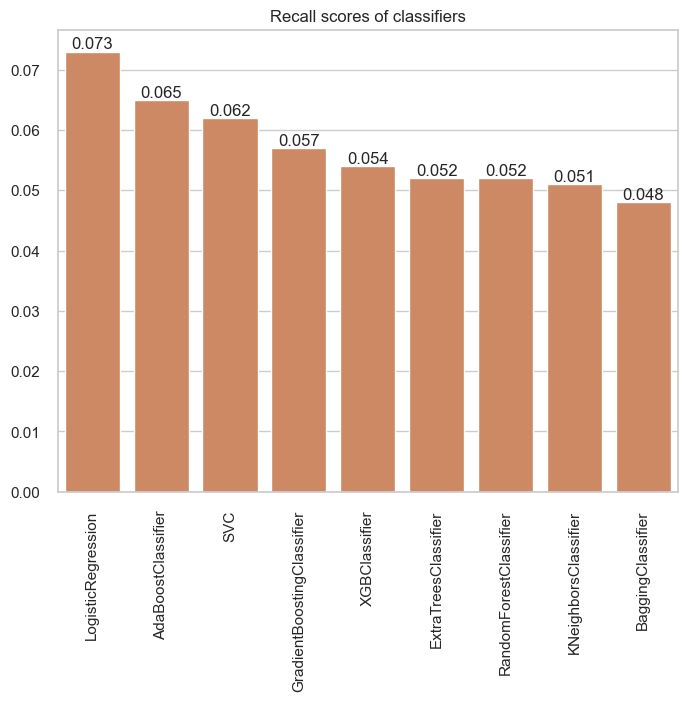

In [96]:
scores_selected = pd.DataFrame(scores_selected).sort_values("recall_score", ascending = False)
plot_bars(scores_selected, "recall_score", "", "Recall scores of classifiers")

It can be seen that scores are a bit lower than in the initial set of features but still much better than random guesssing.

#### Hyperparameter tuning - Bayesian optimization

Hyperparameter tuning with the Bayesian optimization was inteded to be performed for the dataset with features selected manually. For that purpose it was supposed that the Optuna study function would be run on preprocessed and resampled datasets with 7 features (manual feature selection; see above). 

However, due to the limited computer power, the Optuna function (bellow) was stopped before the process was finished (it took long time tu run).

In [59]:
X_pipe = pd.DataFrame(preprocessor.fit_transform(X))
X_pipe_train = pd.DataFrame(preprocessor.fit_transform(X_train))
X_pipe_val = pd.DataFrame(preprocessor.fit_transform(X_val))
X_pipe_test = pd.DataFrame(preprocessor.fit_transform(X_test))

In [41]:
smote = SMOTE()
X_resampled_train, y_resampled_train = smote.fit_resample(X_pipe_train, y_train)


In [60]:
preprocessor.get_feature_names_out()

array(['numeric__emp_length', 'numeric__risk_score',
       'numeric__loan_amount', 'numeric__dti',
       'categorical__loan_status_Charged Off',
       'categorical__loan_status_Current',
       'categorical__loan_status_Fully Paid',
       'categorical__loan_status_In Grace Period'], dtype=object)

In [61]:
X_pipe_train.columns = X_pipe_val.columns = X_pipe_test.columns = X_pipe.columns = ['numeric__emp_length', 
        'numeric__risk_score',
       'numeric__loan_amount', 'numeric__dti',
       'categorical__loan_status_Charged Off',
       'categorical__loan_status_Current',
       'categorical__loan_status_Fully Paid',
       'categorical__loan_status_In Grace Period']

In [103]:
def objective(trial):
    classifier_name = trial.suggest_categorical('classifier', ['XGB', 'RF', 'ET', 'GB', 'LR', 'SVC', 'KNN', 'Bagging', 'AdaBoost'])

    if classifier_name == 'XGB':
        classifier = xgb.XGBClassifier(
        n_estimators = trial.suggest_int("n_estimators", 100,1000, step = 100),
        max_depth = trial.suggest_int('max_depth', 3, 9, step = 3),
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log = True),
        subsample = trial.suggest_float('subsample', 0.6, 1, step = 0.2)
        )
        classifier.fit(X_resampled_train, y_resampled_train)

    elif classifier_name == 'RF':
        classifier = RandomForestClassifier(
        n_estimators = trial.suggest_int("n_estimators", 10,101, step = 10),
        max_depth = trial.suggest_int("rf_max_depth", 2, 64, log=True),
        max_samples = trial.suggest_float("max_samples",0.2, 1),
        random_state = 42
        )
        classifier.fit(X_resampled_train, y_resampled_train)
        
    elif classifier_name == 'ET':
        classifier = ExtraTreesClassifier(
        n_estimators = trial.suggest_int("n_estimators", 100,500, step = 200),
        max_depth = trial.suggest_int('max_depth',1, 9, step = 4),
        )
        classifier.fit(X_resampled_train, y_resampled_train)
        
    elif classifier_name == 'GB':
        classifier = GradientBoostingClassifier(
        n_estimators = trial.suggest_int("n_estimators", 100,500, step = 200),
        max_depth = trial.suggest_int("rf_max_depth", 2, 64, log=True),
        learning_rate=trial.suggest_float('learning_rate', 0.01, 0.3, log = True)
        )
        classifier.fit(X_resampled_train, y_resampled_train)
        
    elif classifier_name == 'LR':
        classifier = LogisticRegression(
            C=trial.suggest_float('C', 1, 9, step = 4),
            penalty=trial.suggest_categorical('penalty', ['l1', 'l2']),
            solver=trial.suggest_categorical('solver', ['liblinear', 'saga'])
        )
        classifier.fit(X_resampled_train, y_resampled_train)
        
    elif classifier_name == 'SVC':
        classifier = SVC(
            C=trial.suggest_float('C', 1, 9, step = 4),
            kernel=trial.suggest_categorical('kernel', ['linear', 'rbf', 'sigmoid']),
            gamma=trial.suggest_categorical('gamma', ['scale', 'auto'])
        )
        classifier.fit(X_resampled_train, y_resampled_train)
        
    elif classifier_name == 'KNN':
        classifier = KNeighborsClassifier(
            n_neighbors=trial.suggest_int('n_neighbors', 3, 7, step = 2),
            weights=trial.suggest_categorical('weights', ['uniform', 'distance']),
            leaf_size=trial.suggest_int('leaf_size', 30, 90, step = 30)
        )
        classifier.fit(X_resampled_train, y_resampled_train)
        
    elif classifier_name == 'Bagging':
        classifier = BaggingClassifier(
            n_estimators=trial.suggest_int('n_estimators', 10, 90, step = 20),
            max_samples=trial.suggest_float('max_samples', 0.5, 0.9, step = 0.2),
        )
        classifier.fit(X_resampled_train, y_resampled_train)
        
    else:
        classifier = AdaBoostClassifier(
            n_estimators=trial.suggest_int('n_estimators', 50, 200, step = 50),
            learning_rate=trial.suggest_float('learning_rate', 0.01, 10.0, log = True)
        )
        classifier.fit(X_resampled_train, y_resampled_train)
    
    y_pred = classifier.predict(X_pipe_val)
    score = accuracy_score(y_val, y_pred)

    return score


In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = 100)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

#### Predicting values and evaluating tuned models on the test dataset

Instead of the model tuned by the Bayesian optimization, for the further assessment on the test data it was decided to use the classifier which generated good accuracy and recall scores after 7 features were selected manually - the Gradient Boosting classifier (accuracy score - 0.072; recall score - 0.057).

In [44]:
model = joblib.load('model_selected_subgrade3.joblib')

GradientBoostingClassifier


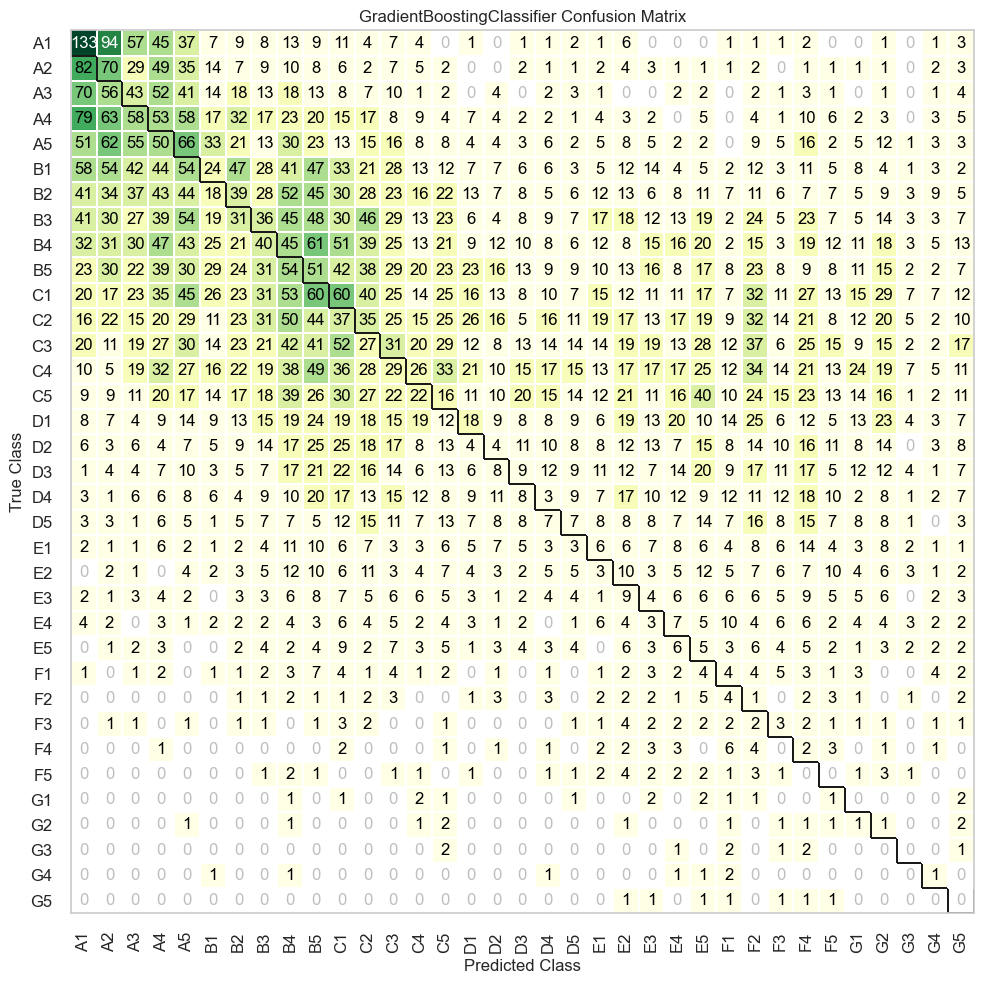

Accuracy score: 0.068
F1 score: 0.048
Precision: 0.05
Recall: 0.059


In [52]:
prediction = model.predict(X_test)

# Metrics:
prec = precision_score(y_test, prediction, average='macro').round(3)
rec = recall_score(y_test, prediction, average='macro').round(3)
acc_sq = accuracy_score(y_test, prediction).round(3)
f1 = f1_score(y_test, prediction, average='macro').round(3)

#Prints:
print (model[2].__class__.__name__)
conf = confusion_matrix(
    model, X_resampled_train, y_train, X_test, y_test, classes=classes_subgrade,
    cmap="YlGn", size=size_subgrade)
print (f"Accuracy score: {acc_sq}")
print (f"F1 score: {f1}")
print (f"Precision: {prec}")
print (f"Recall: {rec}")

It can be seen that the Gradient Boosting classifier performs similarly on the test data as on the validation data. This model will be used for the prediction based on the user input data.

#### Using the selected model for prediction

In [53]:
inp1 = int(input("How many years has the applicant been employed?: "))
inp2 = float(input("What is the risk score of the applicant?: "))
inp3 = int(input("What is the loan amount the applicant requested?: "))
inp4 = float(input("What is the debt-to-income ratio of the applicant?: "))
inp5 = int(input("What is the applicant charged off? 0 - No; 1 - Yes: "))
inp6 = int(input("What is the applicant current receiver of a loan? 0 - No; 1 - Yes: "))
inp7 = int(input("What is the applicant fully paid? 0 - No; 1 - Yes: "))
inp8 = int(input("What is the applicant in grace period? 0 - No; 1 - Yes: "))

How many years has the applicant been employed?: 10
What is the risk score of the applicant?: 700
What is the loan amount the applicant requested?: 5000
What is the debt-to-income ratio of the applicant?: 20
What is the applicant charged off? 0 - No; 1 - Yes: 0
What is the applicant current receiver of a loan? 0 - No; 1 - Yes: 1
What is the applicant fully paid? 0 - No; 1 - Yes: 0
What is the applicant in grace period? 0 - No; 1 - Yes: 0


In [66]:
X_prediction = X_pipe_test.copy()

In [71]:
len(X_prediction)

12001

In [68]:
X_prediction.loc[len(X_prediction.index)] = [inp1, inp2, inp3, inp4, inp5, inp6, inp7, inp8] 

In [70]:
prob = []
pred = []
prob = model[2].predict_proba(X_prediction)
pred = model[2].predict(X_prediction)

print(f' It is predicted that the applicants grade is {[k for k, v in labels.items() if v == pred[12000]]}.')

 It is predicted that the applicants grade is ['B1'].


### Conclusions for the IV part

From this part of the analysis it can be concluded:
   1. Grades of persons whose loan applications are accepted can be predicted with such features as:
   
   - employment length (persons with the longer employment length will get higher subgrade);
   
   - risk score (persons whose risk score is higher will get higher subgrade);
   
   - loan amount (applications for higher amounts of loans will get higher subgrade); and
   
   - debt to income ration (persons with higher debt to income ratios will get lower subgrade).
   
   2. the Gradient Boosting classifier provides both good accuracy, precision and recall scores and performs similarly both on test and validation data (accuracy score - 0.068, recall score - 0.059, precision score - 0.05). The score are two or three times better than random guessing (probability - 1/35 or 0.02). The model much better predicts values that are more frequent (such as subgrades of A, B, and C) rather then les frequent values. 
   